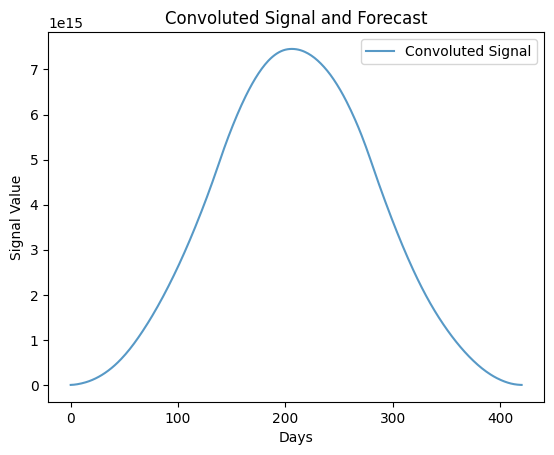

Ethereum Mean Forecast Shape: (10,)
Ethereum Mean Forecast Array:
 [3474.2617 3574.2405 3449.267  3624.2302 3099.3416 2999.3628 3049.3523
 3024.3574 3024.3574 3049.3523]
Gold Mean Forecast Shape: (10,)
Gold Mean Forecast Array:
 [2085.0076 2101.425  2117.8423 2101.425  2101.425  2068.5903 2068.5903
 2052.1729 2035.7556 2035.7556]
Bitcoin Mean Forecast Shape: (10,)
Bitcoin Mean Forecast Array:
 [63288.8   65206.64  68083.41  70480.71  67603.945 69521.79  69042.33
 67124.484 65686.1   65206.64 ]
Convolution Mean Forecast Shape: (10,)
Convolution Mean Forecast Array:
 [ 4.6442368e+07  4.6442368e+07  4.6442368e+07 -2.4373025e+13
 -2.4373025e+13 -2.4373025e+13 -2.4373025e+13 -2.4373025e+13
 -2.4373025e+13 -2.4373025e+13]


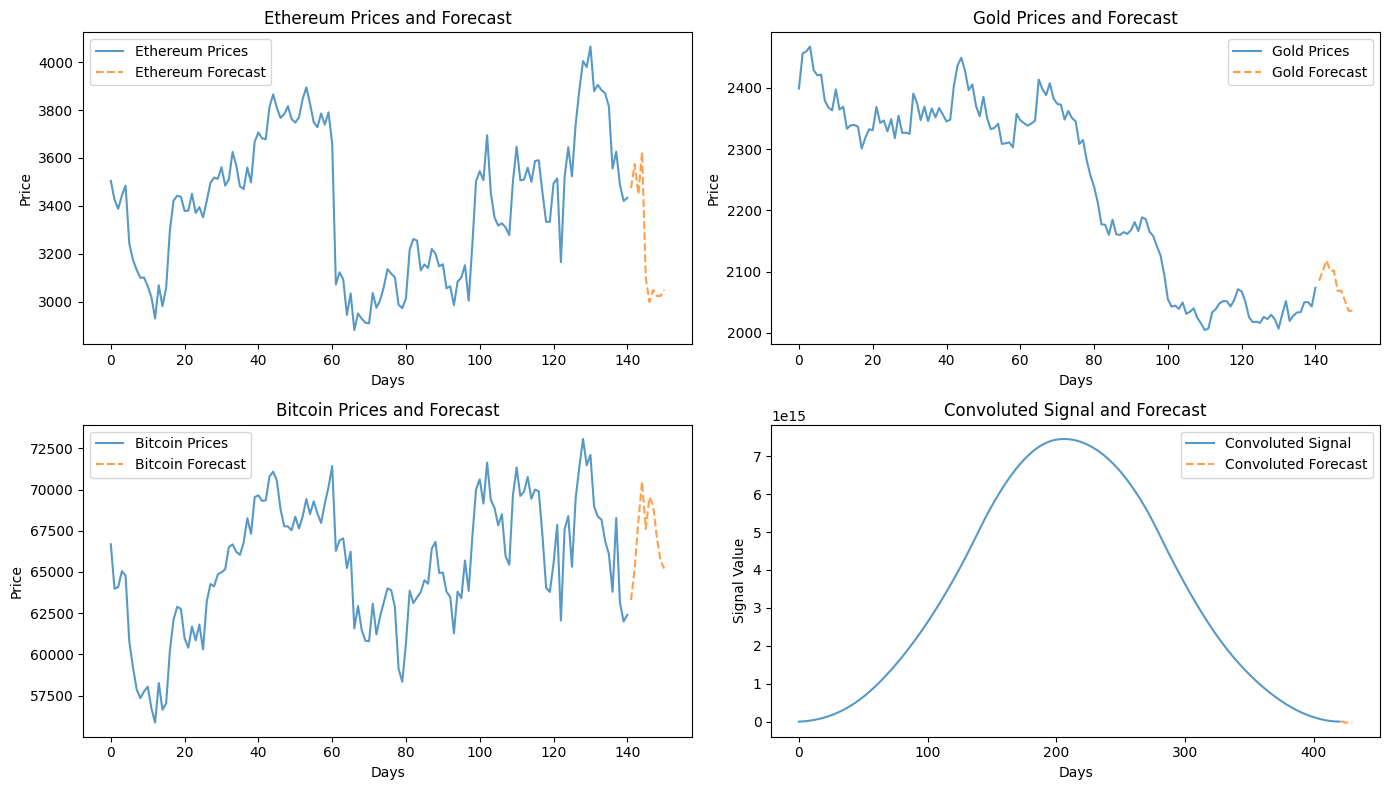

In [2]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt

# Load the datasets
ethereum_path = "/data_files/ethereum_prices.csv"
gold_path = "/data_files/gold_prices.csv"
bitcoin_path = "/data_files/bitcoin_prices.csv"

ethereum_df = pd.read_csv(ethereum_path)
gold_df = pd.read_csv(gold_path)
bitcoin_df = pd.read_csv(bitcoin_path)

# Extract the 'Price' columns as numpy arrays
ethereum_prices = ethereum_df['Price'].values
gold_prices = gold_df['Price'].values
bitcoin_prices = bitcoin_df['Price'].values

# Ensure all streams are the same length by trimming/padding
min_length = min(len(ethereum_prices), len(gold_prices), len(bitcoin_prices))
ethereum_prices = ethereum_prices[:min_length]
gold_prices = gold_prices[:min_length]
bitcoin_prices = bitcoin_prices[:min_length]

# Convolute the signals
convolution_eg = np.convolve(ethereum_prices, gold_prices, mode='full')
convolution_all = np.convolve(convolution_eg, bitcoin_prices, mode='full')

plt.plot(convolution_all, label='Convoluted Signal', alpha=0.75)
plt.title("Convoluted Signal and Forecast")
plt.xlabel('Days')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

# Convert the streams to tensors
ethereum_tensor = torch.tensor(ethereum_prices, dtype=torch.float32)
gold_tensor = torch.tensor(gold_prices, dtype=torch.float32)
bitcoin_tensor = torch.tensor(bitcoin_prices, dtype=torch.float32)
convolution_tensor = torch.tensor(convolution_all, dtype=torch.float32)
#convolution_tensor = torch.tensor(gold_prices, dtype=torch.float32)

# Initialize the Chronos pipeline
forecast_len = 10
num_samples = 1  # Shared across all predictions
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Predict for each individual asset
ethereum_forecast = pipeline.predict(
    context=ethereum_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

gold_forecast = pipeline.predict(
    context=gold_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

bitcoin_forecast = pipeline.predict(
    context=bitcoin_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

# Predict for the convoluted signal
convolution_forecast = pipeline.predict(
    context=convolution_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

# Convert the forecasts to numpy arrays and calculate the mean
ethereum_forecast = ethereum_forecast.squeeze(0)
ethereum_forecast_values = ethereum_forecast.numpy().mean(axis=0)
print("Ethereum Mean Forecast Shape:", ethereum_forecast_values.shape)
print("Ethereum Mean Forecast Array:\n", ethereum_forecast_values)

gold_forecast = gold_forecast.squeeze(0)
gold_forecast_values = gold_forecast.numpy().mean(axis=0)
print("Gold Mean Forecast Shape:", gold_forecast_values.shape)
print("Gold Mean Forecast Array:\n", gold_forecast_values)

bitcoin_forecast = bitcoin_forecast.squeeze(0)
bitcoin_forecast_values = bitcoin_forecast.numpy().mean(axis=0)
print("Bitcoin Mean Forecast Shape:", bitcoin_forecast_values.shape)
print("Bitcoin Mean Forecast Array:\n", bitcoin_forecast_values)

convolution_forecast = convolution_forecast.squeeze(0)
convolution_forecast_values = convolution_forecast.numpy().mean(axis=0)
print("Convolution Mean Forecast Shape:", convolution_forecast_values.shape)
print("Convolution Mean Forecast Array:\n", convolution_forecast_values)

# Plotting the original signals and their forecasts
plt.figure(figsize=(14, 8))

# Plot Ethereum
plt.subplot(2, 2, 1)
plt.plot(ethereum_prices, label='Ethereum Prices', alpha=0.75)
plt.plot(range(len(ethereum_prices), len(ethereum_prices) + forecast_len), 
         ethereum_forecast_values, label='Ethereum Forecast', linestyle='--', alpha=0.75)
plt.title("Ethereum Prices and Forecast")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Plot Gold
plt.subplot(2, 2, 2)
plt.plot(gold_prices, label='Gold Prices', alpha=0.75)
plt.plot(range(len(gold_prices), len(gold_prices) + forecast_len), 
         gold_forecast_values, label='Gold Forecast', linestyle='--', alpha=0.75)
plt.title("Gold Prices and Forecast")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Plot Bitcoin
plt.subplot(2, 2, 3)
plt.plot(bitcoin_prices, label='Bitcoin Prices', alpha=0.75)
plt.plot(range(len(bitcoin_prices), len(bitcoin_prices) + forecast_len), 
         bitcoin_forecast_values, label='Bitcoin Forecast', linestyle='--', alpha=0.75)
plt.title("Bitcoin Prices and Forecast")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Plot Convoluted Signal
plt.subplot(2, 2, 4)
plt.plot(convolution_all, label='Convoluted Signal', alpha=0.75)
plt.plot(range(len(convolution_all), len(convolution_all) + forecast_len), 
         convolution_forecast_values, label='Convoluted Forecast', linestyle='--', alpha=0.75)
plt.title("Convoluted Signal and Forecast")
plt.xlabel('Days')
plt.ylabel('Signal Value')
plt.legend()

plt.tight_layout()
plt.show()
